<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/ShopeeImagePreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

## Import

In [1]:
!git clone https://github.com/bluezdot/ShopeeImage.git

Cloning into 'ShopeeImage'...
remote: Enumerating objects: 32484, done.
remote: Total 32484 (delta 0), reused 0 (delta 0), pack-reused 32484
Receiving objects: 100% (32484/32484), 1.68 GiB | 35.70 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Checking out files: 100% (32428/32428), done.


In [2]:
%cd ShopeeImage/dataset/data_use

/content/ShopeeImage/dataset/data_use


In [3]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 11.8 MB/s 
     |████████████████████████████████| 948 kB 68.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=2bc003da0d0fd7478493ae5a974a049e4faba08fa1f34fac5ba6c6a9522764cc
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
from albumentations.augmentations import transforms
import albumentations as A
import albumentations.pytorch
from albumentations.pytorch import ToTensorV2

In [5]:
train_img_path = './train_images'
test_img_path = './test_images'
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [6]:
def my_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Drop duplicated phash images

In [7]:
# drop duplicate by p-hash
train_df = train_df.drop_duplicates(subset=['image_phash'],keep = 'first')
train_df.image_phash.value_counts()

9e1fe0cc1dd2b606    1
e8d2956a6aa96993    1
e635c999c8ce2663    1
fa6a8590c1c5cf3a    1
86934f3c396d2699    1
                   ..
af363198cd9892cb    1
fb7c868380d612db    1
a6bddd40dad3b204    1
ec978472962c9b36    1
f8c2853dc3e83a93    1
Name: image_phash, Length: 28735, dtype: int64

In [8]:
# check if label group preserved
train_df.label_group.value_counts()

1141798720    44
159351600     43
1091404026    39
3489985175    37
562358068     36
              ..
370710977      1
3601891778     1
2067677642     1
2213950251     1
1332066608     1
Name: label_group, Length: 11004, dtype: int64

## Augmentation

In [11]:
class ShopeeDataset(Dataset):

    def __init__(self, dataframe, dir_path, transforms):
        self.dataframe = dataframe
        self.dir_path = dir_path
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_info = self.dataframe.iloc[index]
        
        img = cv2.imread(self.dir_path + '/' + img_info['image'])
        label = torch.tensor([img_info['label_group']])

        if self.transforms:
            augmented = self.transforms(image=img) 
            img = augmented['image']

        return img, label


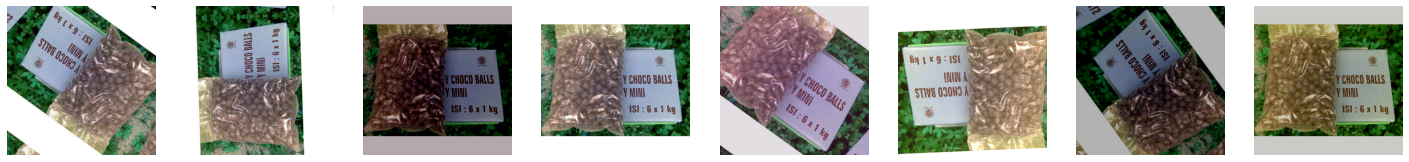

In [58]:
albumentations_transforms = A.Compose([
    A.Resize(300, 300, interpolation = cv2.INTER_LANCZOS4),
    A.ShiftScaleRotate(rotate_limit=180, p=0.5, interpolation = cv2.INTER_LANCZOS4),
    A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()])

train_ds = ShopeeDataset(train_df, train_img_path, albumentations_transforms)

my_seed(32)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
# visualize a batch
num_samples = 8
fig, ax = plt.subplots(1, num_samples, figsize=(25, 10))

for i in range(num_samples):
    ax[i].imshow((train_ds[21][0]).permute(1, 2, 0))
    ax[i].axis('off')

#i = iter(train_dl)
#plt.figure(figsize=(20, 5))
#j = 1
#for im in next(i)[0]:
#    plt.subplot(1, 4, j)
#    j += 1
#    plt.imshow(im.permute(1, 2, 0))